In [1]:
import mlflow

mlflow.autolog()

In [2]:
import pandas as pd
import duckdb
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Q1 How many columns in the data

january_data = pd.read_parquet("../files/yellow_tripdata_2022-02.parquet")

len(january_data.columns)
## 19 columns

2023/05/30 11:58:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


19

In [3]:
## Q2 Calculate the std deviation of the trip duration from the dataset

df = january_data

df["duration"] = duckdb.query("SELECT DATE_DIFF('minute', tpep_pickup_datetime, tpep_dropoff_datetime) AS duration \
                         FROM df").df()

df["duration"].std()
## 46.45 minutes std deviation of ride duration

46.44854215366145

In [4]:
## Q3 Trim the data by only including the data range [1,60] minutes

c1 = df["duration"].count()
print(c1)

df = duckdb.query("SELECT * FROM df\
                   WHERE duration BETWEEN 1 AND 60").df()

c2 = df["duration"].count()
print(c2)

print(f"{round((c2/c1)*100,2)}% of the records are left after trimming.")
## 98%

2463931
2431555
98.69% of the records are left after trimming.


In [5]:
## Q4 Perform One-hot encoding with the features as Pickup location, Drop off location, and trip distance
## Check the number of columns of the output feature matrix (dimensionality)

df[["PULocationID","DOLocationID"]] = df[["PULocationID","DOLocationID"]].astype(str)

dfdict = df[["PULocationID","DOLocationID","trip_distance"]].to_dict(orient='records')
dv = DictVectorizer()

X_train = dv.fit_transform(dfdict)
# X_train
len(dv.feature_names_)
## 516 is the dimensionality of this matrix


516

In [6]:
## Q5 Train a linear regression model from the X values (feature matrix) and the Y values (duration)

Y_train = df["duration"].values
# Y_train
lr = LinearRegression()
lr.fit(X_train,Y_train)

2023/05/30 11:58:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8072679598274523bcd36bc6e6b9f7cb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


LinearRegression()

/tmp/ipykernel_16758/4222732333.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(Y_pred, label="prediction")
/tmp/ipykernel_16758/4222732333.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(Y_train, label="actual")


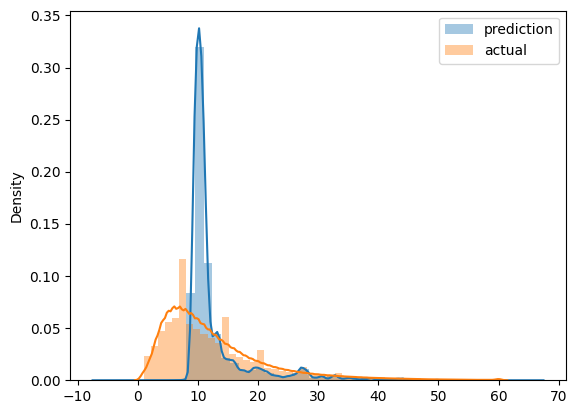

In [7]:
## Plot the actual and predicted data

Y_pred = lr.predict(X_train)

sn.distplot(Y_pred, label="prediction")
sn.distplot(Y_train, label="actual")

plt.legend()

In [8]:
## Q5 What is the Root Mean Square Error of the model on training data

mean_squared_error(Y_train, Y_pred, squared=False)
## RMSE ~ 7.11

7.106362196516991

In [9]:
## Evaluate the model on Feb 2022 data

df_val = pd.read_parquet('../files/yellow_tripdata_2022-03.parquet')

df_val["duration"] = duckdb.query("SELECT DATE_DIFF('minute', tpep_pickup_datetime, tpep_dropoff_datetime) AS duration \
                               FROM df_val").df()

df_val = duckdb.query("SELECT * FROM df_val\
                   WHERE duration BETWEEN 1 AND 60").df()

val_dicts = df_val[["PULocationID","DOLocationID","trip_distance"]].to_dict(orient='records')

X_val = dv.transform(val_dicts)

Y_val = df_val["duration"].values

In [10]:
## Q6 What is the RMSE on Feb 2022 validation data

Y_pred=lr.predict(X_val)

mean_squared_error(Y_val, Y_pred, squared=False)
## RMSE ~ 12.3

12.303802379897524